In [37]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from plotting import multiple_histograms_plot
from pipeline import LogFeaturesTransform
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from auto_lgbm import find_n_estimators, grid_search

from sklearn.metrics import log_loss
from evaluation import predictions_hist, confusion_matrix_report, grid_search_report

import shap
import matplotlib.pyplot as plt
import math

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


from sklearn.metrics import log_loss
from evaluation import predictions_hist, confusion_matrix_report, grid_search_report

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
print(df.Class.value_counts())
print()
print(df['Class'].mean()) 

0    284315
1       492
Name: Class, dtype: int64

0.001727485630620034


In [4]:
y = df[['Class']]

In [5]:
x = df.drop(columns='Class')

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, stratify=y, random_state=1)

In [7]:
ytrain.sum()

Class    394
dtype: int64

In [8]:
ytest.sum()

Class    98
dtype: int64

In [9]:
xtrain_true = xtrain[ytrain['Class'] == 1] 
xtrain_false = xtrain[ytrain['Class'] == 0]

In [10]:
xtrain_true.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,...,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,80499.611675,-4.613735,3.536156,-6.878303,4.468144,-3.018317,-1.406307,-5.330795,0.657250,-2.445369,...,0.326114,0.825200,-0.020084,-0.063944,-0.107400,0.056199,0.039361,0.198264,0.096053,123.349086
std,48162.787760,6.608897,4.168226,6.963960,2.844114,5.295959,1.916835,6.939668,6.902580,2.451831,...,1.357058,3.886912,1.482234,1.688020,0.520988,0.806648,0.467572,1.251943,0.533844,252.859298
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000
25%,41290.000000,-5.972454,1.134992,-8.606982,2.300244,-4.758199,-2.559963,-7.801176,-0.135707,-3.828323,...,-0.178603,0.098377,-0.521865,-0.349276,-0.434334,-0.299993,-0.262623,-0.020917,-0.067442,1.000000
50%,74647.500000,-2.304607,2.679071,-5.050324,4.136683,-1.402998,-1.424616,-2.843863,0.621508,-1.991845,...,0.270066,0.596733,0.049493,-0.080102,-0.061408,0.106593,-0.009778,0.386073,0.148218,10.495000
75%,128576.000000,-0.357602,4.904522,-2.093609,6.283622,0.320265,-0.357445,-0.898702,1.812047,-0.753221,...,0.817065,1.295662,0.615132,0.308483,0.287740,0.481128,0.388845,0.797768,0.384480,105.620000
max,170348.000000,2.132386,22.057729,2.041003,11.927512,11.095089,6.474115,5.802537,20.007208,3.353525,...,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,1809.680000


In [11]:
xtrain_false.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,...,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000,227451.000000
mean,94732.229364,0.007278,-0.007161,0.014476,-0.003894,0.002367,0.004524,0.009256,-0.001045,0.004479,...,-0.001362,-0.001406,0.000934,0.000877,-0.000195,0.000039,-0.000369,-0.000389,-0.000193,88.649291
std,47518.510340,1.925116,1.622239,1.459825,1.401090,1.361337,1.331251,1.186733,1.166301,1.087899,...,0.766427,0.715130,0.723361,0.613299,0.605862,0.521554,0.482210,0.402095,0.330567,250.017768
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-54.497720,-34.830382,-10.933144,-36.666000,-2.836627,-8.696627,-2.534330,-22.565679,-15.430084,0.000000
25%,54116.000000,-0.920264,-0.601080,-0.882790,-0.845815,-0.691651,-0.764770,-0.552959,-0.208346,-0.639557,...,-0.212155,-0.228083,-0.541120,-0.162018,-0.354109,-0.317501,-0.327644,-0.070772,-0.053007,5.610000
50%,84619.000000,0.018690,0.063001,0.183126,-0.019510,-0.054424,-0.270864,0.040143,0.022345,-0.049892,...,-0.062945,-0.029477,0.007580,-0.011120,0.041103,0.016918,-0.052640,0.001249,0.011201,22.000000
75%,139273.000000,1.315650,0.798255,1.028862,0.741542,0.611213,0.402013,0.569897,0.327020,0.597545,...,0.132297,0.185868,0.529244,0.147692,0.438716,0.351194,0.240428,0.090556,0.078027,77.760000
max,172792.000000,2.451888,18.902453,9.382558,16.715537,34.801666,73.301626,120.589494,18.709255,15.594995,...,39.420904,22.599543,10.503090,22.083545,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


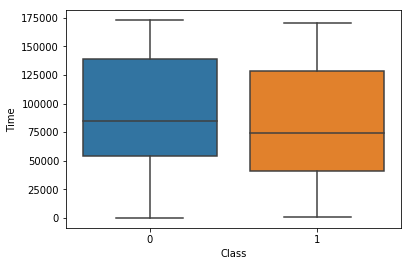

In [12]:
sns.boxplot(x=ytrain.Class,y=xtrain.Time)

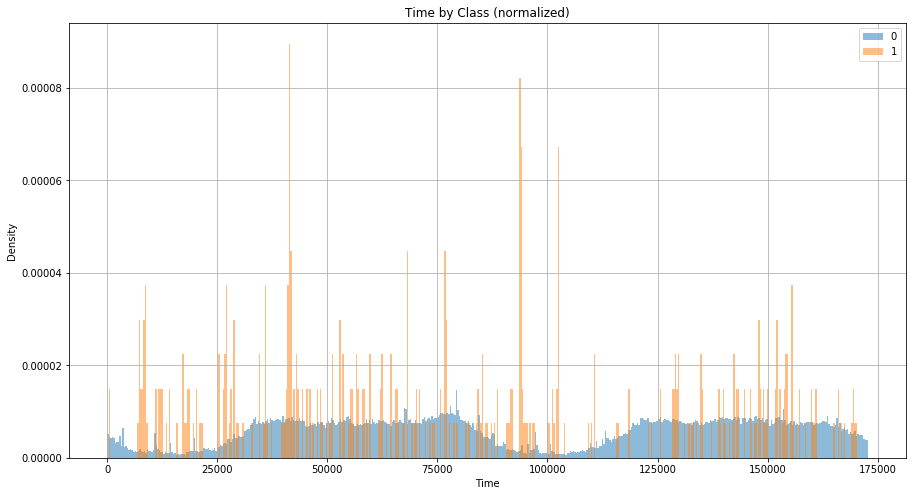

In [13]:
a= pd.concat([xtrain,ytrain], axis=1, sort=True)

multiple_histograms_plot(data=a, x='Time', hue='Class', density=True, bins=500)

In [14]:
# data = [go.Histogram(x=a['Time'], nbinsx=500)]

# iplot(data, filename='histogram time')

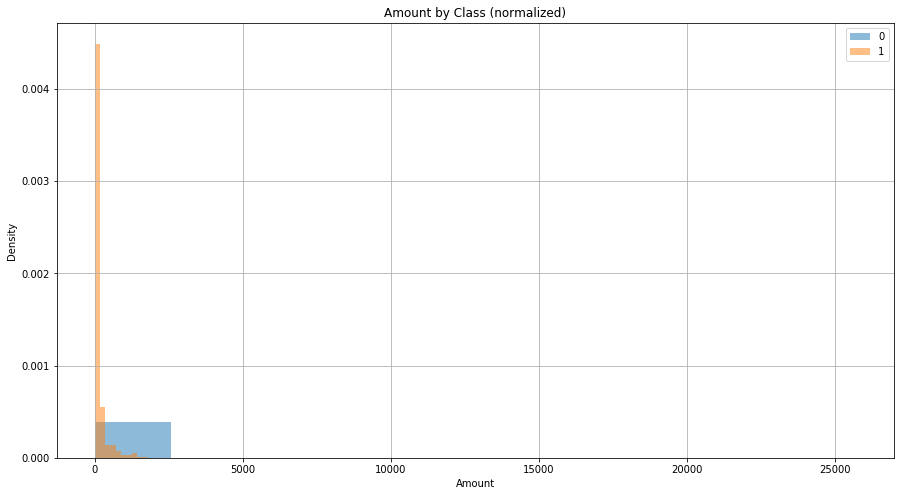

In [15]:
multiple_histograms_plot(data=a, x='Amount', hue='Class', density=True, bins=10)

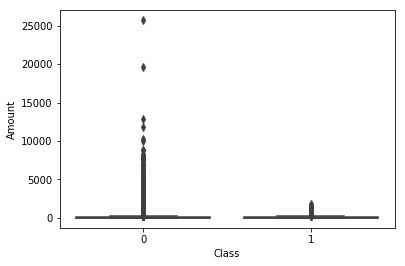

In [16]:
sns.boxplot(x=ytrain.Class,y=xtrain.Amount)

In [17]:
a = a.assign(amount_1=lambda x: x.Amount+1)

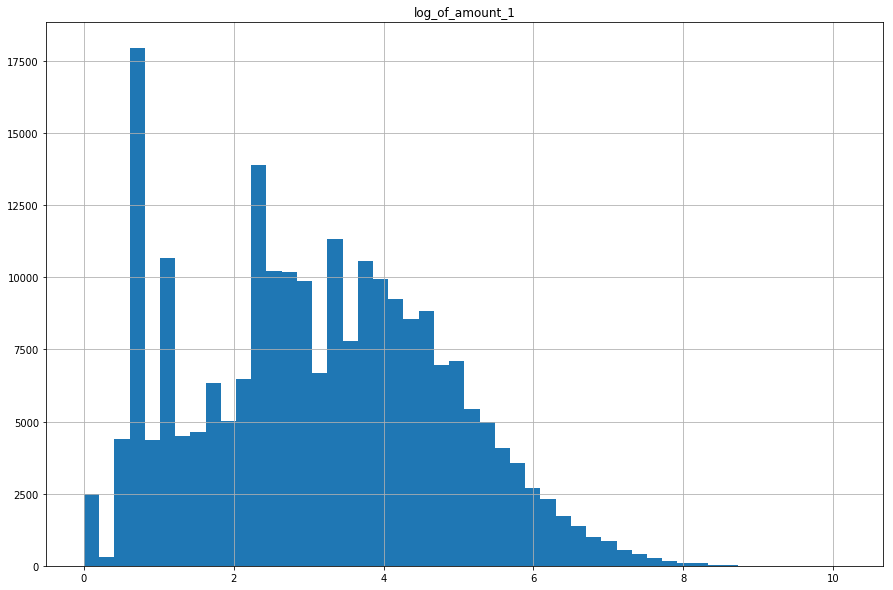

In [18]:
log_cols = ['amount_1']

a = LogFeaturesTransform(log_cols).fit_transform(a)

new_cols = [f"log_of_{c}" for c in log_cols]
_ = a[new_cols].hist(bins=50, figsize=(15,10))

In [19]:
a.log_of_amount_1.describe()

count    227845.000000
mean          3.154391
std           1.659342
min           0.000000
25%           1.879465
50%           3.135494
75%           4.368054
max          10.153941
Name: log_of_amount_1, dtype: float64

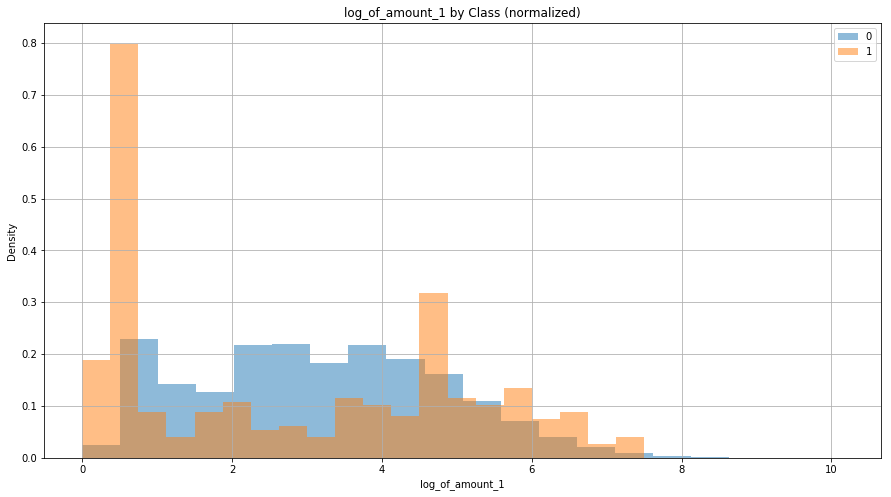

In [20]:
multiple_histograms_plot(data=a, x='log_of_amount_1', hue='Class', density=True, bins=20)

In [40]:
ytrain = ytrain['Class']
ytest = ytest['Class']

In [77]:
rf = RandomForestClassifier(n_estimators=15,n_jobs=-1, criterion='entropy', )
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
ytrain_pred = rf.predict(xtrain)
ytest_pred = rf.predict(xtest)

print('AUC no treino:', roc_auc_score(ytrain, ytrain_pred))
print('AUC no teste:', roc_auc_score(ytest, ytest_pred))

AUC no treino: 0.984771573604061
AUC no teste: 0.93361191902197


             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.92      0.87      0.89        98

avg / total       1.00      1.00      1.00     56962

Matrix em teste: None


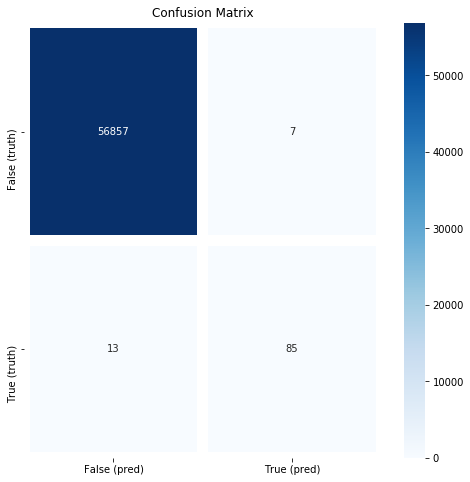

In [88]:
y_pred_proba_test= rf.predict_proba(xtest)

print('Matrix em teste:', confusion_matrix_report(ytest, y_pred_proba_test[:,1]))

In [81]:
log_loss(ytest, ytest_pred)

0.012127051807876862